# Description

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm


# General settings

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [3]:
device

'cpu'

# Generating datapoints

In [4]:
def generate_regression_point(x, mean=0, std=0.02):
    # Create sample from noise random variable 
    mean = mean
    std = std
    epsilon = np.random.normal(loc=mean, scale=std)
    # Create noisy x
    x_noisy = x + epsilon
    
    # Create output value
    y = x_noisy + 0.3*np.sin(2*math.pi*(x_noisy)) + 0.3*np.sin(4*math.pi*((x_noisy)))
    return y

In [5]:
# Generate dataset
# X = torch.tensor([-4, -3, -2, -1, 1, 2, 3, 4]).reshape(-1,1)
X = torch.linspace(0, 10, 100, dtype=torch.float32).reshape(-1,1)
y = generate_regression_point(X)

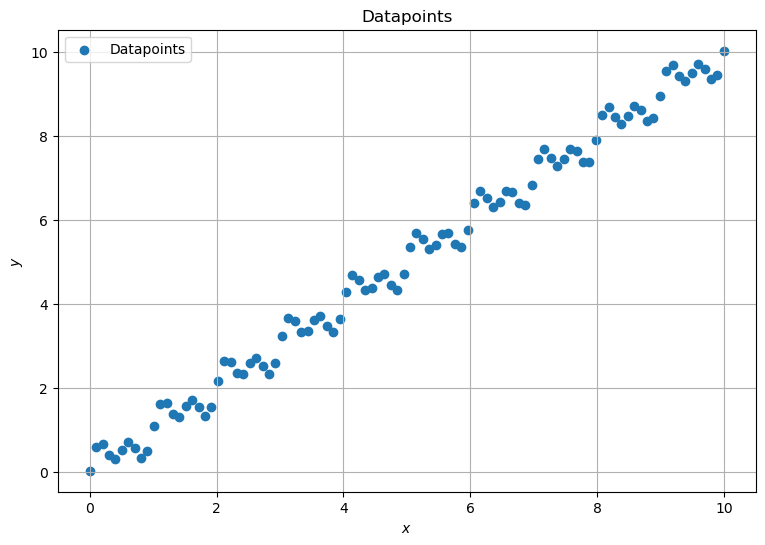

In [6]:
plt.figure(figsize=(9, 6))
plt.scatter(X, y, label="Datapoints")
plt.title("Datapoints")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.grid()
plt.show()

# Learning the regression function with a standard neural network

In [7]:
class Neural_Network(nn.Module):
    def __init__(self, hidden_size=32):
        super().__init__()
        self.l1 = nn.Linear(1, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.l4 = nn.Linear(hidden_size, 1)
        self.act = nn.Sigmoid()

    def forward(self, x):
        x = self.act(self.l1(x))
        x = self.act(self.l2(x))
        x = self.act(self.l3(x))
        x = self.l4(x)
        return x

In [8]:
# Initialize neural network
net1 = Neural_Network(hidden_size=32).to(device)

# Specify the loss - MSE loss for regression
loss_fn = nn.MSELoss()

# Specify optimizer - Stochastic Gradient Descent optimizer
optimizer = torch.optim.SGD(net1.parameters(), lr=0.05)

# Train the model
epochs = 10000

for epoch in tqdm(range(epochs)):
    # zero gradients
    optimizer.zero_grad()
    # pass forward 
    y_pred = net1(X.to(device))
    # evaluate performance
    loss = loss_fn(y_pred, y.to(device))
    # calculate the gradients
    loss.backward()
    # update weights
    optimizer.step()
    # print progress
    if epoch % 1000 == 0:
        print("loss: {} | epoch {}".format(loss, epoch))
print('Training complete')

  0%|          | 37/10000 [00:00<00:27, 360.60it/s]

loss: 26.891263961791992 | epoch 0


 11%|█         | 1055/10000 [00:02<00:20, 434.06it/s]

loss: 0.3539726734161377 | epoch 1000


 21%|██        | 2104/10000 [00:04<00:14, 540.41it/s]

loss: 0.2009870857000351 | epoch 2000


 31%|███▏      | 3125/10000 [00:06<00:09, 760.71it/s]

loss: 0.13847270607948303 | epoch 3000


 41%|████      | 4117/10000 [00:07<00:07, 780.92it/s]

loss: 0.11427626758813858 | epoch 4000


 51%|█████     | 5121/10000 [00:08<00:06, 768.17it/s]

loss: 0.10363557189702988 | epoch 5000


 61%|██████    | 6102/10000 [00:10<00:04, 793.85it/s]

loss: 0.09818454831838608 | epoch 6000


 71%|███████   | 7091/10000 [00:11<00:03, 782.74it/s]

loss: 0.09509043395519257 | epoch 7000


 81%|████████  | 8068/10000 [00:12<00:02, 786.55it/s]

loss: 0.09320716559886932 | epoch 8000


 91%|█████████ | 9074/10000 [00:14<00:01, 794.30it/s]

loss: 0.09199319034814835 | epoch 9000


100%|██████████| 10000/10000 [00:15<00:00, 635.83it/s]

Training complete


In [9]:
X_test = torch.linspace(0, 10, 20, dtype=torch.float32).reshape(-1,1)

y_pred = net1(X_test.to(device))
y_true = generate_regression_point(X_test)

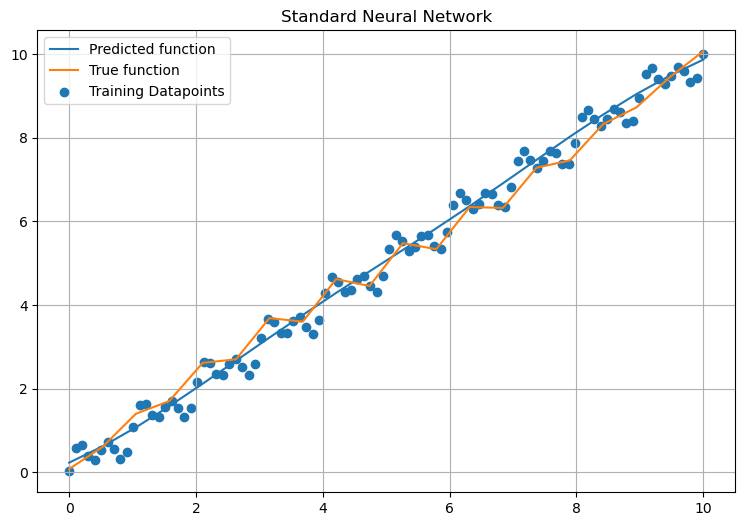

In [10]:
plt.figure(figsize=(9, 6))
plt.plot(X_test.detach().numpy(), y_pred.detach().numpy(), label = "Predicted function")
plt.plot(X_test.detach().numpy(), y_true.detach().numpy(), label = "True function")
plt.scatter(X, y, label = "Training Datapoints")
plt.title("Standard Neural Network")
plt.legend()
plt.grid()
plt.show()

Now, the aim is to verify the extrapolation quality of the model

In [11]:
X_test_large = torch.linspace(-2,10,100).reshape(-1,1)

y_pred_large = net1(X_test_large.to(device))
y_true_large = generate_regression_point(X_test_large)

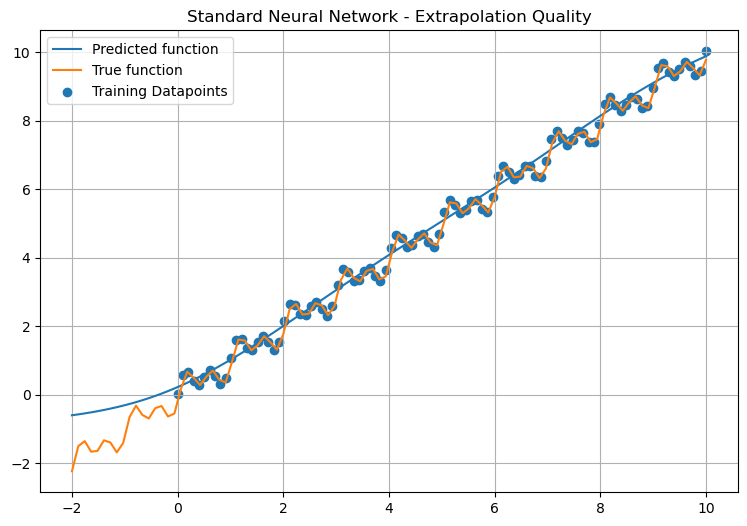

In [12]:
plt.figure(figsize=(9, 6))
plt.plot(X_test_large.detach().numpy(), y_pred_large.detach().numpy(), label = "Predicted function")
plt.plot(X_test_large.detach().numpy(), y_true_large.detach().numpy(), label = "True function")
plt.scatter(X, y, label = "Training Datapoints")
plt.title("Standard Neural Network - Extrapolation Quality")
plt.legend()
plt.grid()
plt.show()

The neural network is overcofindent with regard to predictions outside the data-domain provided during training.

# Learning the regression function with a Bayesian neural network

In [13]:
X_train = torch.linspace(0, 10, 200, dtype=torch.float32).reshape(-1,1)
y_train = generate_regression_point(X_train)

In [14]:
class Bayesian_Layer(nn.Module):
    """
    Layer used for the Bayesian neurwork.
    """
    def __init__(self, input_feats, output_feats, prior_mean=0.0, prior_var=1.0):
        """
        Layer init
        Prior follows a normal distribution with given mean and variance.
        """
        # initialize
        super().__init__()
        
        # Define input and output dims
        self.input_feats = input_feats
        self.output_feats = output_feats
        
        # Initialize mu and sigma for the layer weights
        self.mu_w = nn.Parameter(data = torch.zeros(output_feats, input_feats), requires_grad = True)
        self.sigma_w = nn.Parameter(data = torch.zeros(output_feats, input_feats), requires_grad = True)
        
        # Initialize mu and sigma for the layer bias
        self.mu_b = nn.Parameter(data = torch.zeros(output_feats), requires_grad = True)
        self.sigma_b = nn.Parameter(data = torch.zeros(output_feats), requires_grad = True)
        
        # Define weight and bias samples
        self.w = None
        self.b = None
        
        # Define the weight and bias prior distribution
        self.prior_distrib = torch.distributions.Normal(prior_mean, prior_var)
        
        # Define the distribution for epsilon
        self.eps_distrib = torch.distributions.Normal(0,1)
        
    def forward(self, x):
        """
        The forward function 
        """

        # Perform a weight sampling
        # Sample epsilon
        eps_w = self.eps_distrib.sample(self.mu_w.shape).to(device)
        # Compute weight
        self.w = self.mu_w + eps_w * torch.log(1 + torch.exp(self.sigma_w))
        
        # Perform a bias sampling
        # Sample epsilon
        eps_b = self.eps_distrib.sample(self.mu_b.shape).to(device)
        # Compute bias
        self.b = self.mu_b + eps_b * torch.log(1 + torch.exp(self.sigma_b))
        
        # Calculate log prior
        # Evaluate log probability 
        w_prior_log_prob = self.prior_distrib.log_prob(self.w)
        b_prior_log_prob = self.prior_distrib.log_prob(self.b)
        # Calculate log prior
        self.log_prior = torch.sum(w_prior_log_prob) + torch.sum(b_prior_log_prob)
        
        # Calculate log (variational) posterior
        # Define distributions
        # Weights
        mu_post_w = self.mu_w.data
        sigma_post_w = self.sigma_w.data
        self.post_w_distrib = torch.distributions.Normal(mu_post_w, torch.log(1 + torch.exp(sigma_post_w)))
        # Bias
        mu_post_b = self.mu_b.data
        sigma_post_b = self.sigma_b.data
        self.post_b_distrib = torch.distributions.Normal(mu_post_b, torch.log(1 + torch.exp(sigma_post_b)))
        # Evaluate log probability 
        w_post_log_prob = self.post_w_distrib.log_prob(self.w)
        b_post_log_prob = self.post_b_distrib.log_prob(self.b)
        # Calculate log variational posterior
        self.log_post = torch.sum(w_post_log_prob) + torch.sum(b_post_log_prob)
        
        return F.linear(x, self.w, self.b)

In [15]:
class Bayesian_Network(nn.Module):
    """
    Bayesian Network class.
    """
    def __init__(self, hidden_size=32, tol_noise=0.1, prior_var=1.0):
        # Initialize
        super().__init__()
        
        # Define tolerance to noise
        self.tol_noise = tol_noise
        
        # Define layers
        self.l1 = Bayesian_Layer(input_feats=1, output_feats=hidden_size, prior_var=prior_var)
        self.l2 = Bayesian_Layer(input_feats=hidden_size, output_feats=hidden_size, prior_var=prior_var)
        self.l3 = Bayesian_Layer(input_feats=hidden_size, output_feats=hidden_size, prior_var=prior_var)
        self.l4 = Bayesian_Layer(input_feats=hidden_size, output_feats=1, prior_var=prior_var)
        self.act = nn.Sigmoid()
    
    def forward(self, x):
        # Define the network architecture
        x = self.act(self.l1(x))
        x = self.act(self.l2(x))
        x = self.act(self.l3(x))
        x = self.l4(x)
        return x
    
    def net_log_prior(self):
        # Compute the network's log prior
        return self.l1.log_prior + self.l2.log_prior + self.l3.log_prior + self.l4.log_prior
    
    def net_log_post(self):
        # Compute the network's log posterior
        return self.l1.log_post + self.l2.log_post + self.l3.log_post + self.l4.log_post
    
    def compute_loss(self, inputs, targets):
        """
        Compute the loss. The loss is the negative ELBO.
        """
       
        # Predict outputs
        outputs = self(inputs).reshape(-1) # use network to predict
        
        # compute log prior and posterior
        log_prior = self.net_log_prior() # compute the log prior
        log_post = self.net_log_post() # compute the log posterior
        
        # compute log likelihood
        log_likelihood_distrib = torch.distributions.Normal(outputs, self.tol_noise) 
        log_likelihood = log_likelihood_distrib.log_prob(targets.reshape(-1))
        
        # compute the loss (negative ELBO)
        loss = log_post - log_prior - log_likelihood
        return loss.mean()

In [16]:
# Initialize neural network
net2 = Bayesian_Network(hidden_size=16, tol_noise=0.1, prior_var=1).to(device)

# Specify optimizer - Adam optimizer
optimizer = torch.optim.Adam(net2.parameters(), lr=0.1)

# Train the model
epochs = 3000

for epoch in tqdm(range(epochs)):
    # zero gradients
    optimizer.zero_grad()
    # pass forward and evaluate 
    loss = net2.compute_loss(X_train.to(device), y_train.to(device))
    # calculate the gradients
    loss.backward()
    # update weights
    optimizer.step()
    # print progress
    if epoch % 100 == 0:
        print("loss: {} | epoch {}".format(loss.item(), epoch))
print('Training complete')

  0%|          | 8/3000 [00:00<00:40, 74.14it/s]

loss: 2062.078125 | epoch 0


  4%|▎         | 109/3000 [00:01<00:34, 82.68it/s]

loss: 571.0868530273438 | epoch 100


  7%|▋         | 219/3000 [00:02<00:31, 88.75it/s]

loss: 525.5088500976562 | epoch 200


 10%|█         | 315/3000 [00:03<00:23, 114.43it/s]

loss: 489.8095397949219 | epoch 300


 14%|█▍        | 420/3000 [00:04<00:21, 121.89it/s]

loss: 440.3395690917969 | epoch 400


 17%|█▋        | 519/3000 [00:05<00:21, 115.65it/s]

loss: 435.3564453125 | epoch 500


 20%|██        | 611/3000 [00:06<00:33, 70.94it/s] 

loss: 555.431396484375 | epoch 600


 24%|██▍       | 717/3000 [00:07<00:24, 94.13it/s] 

loss: 525.155517578125 | epoch 700


 27%|██▋       | 809/3000 [00:09<00:43, 50.63it/s]

loss: 535.190673828125 | epoch 800


 30%|███       | 912/3000 [00:10<00:22, 91.46it/s]

loss: 591.2255249023438 | epoch 900


 34%|███▍      | 1013/3000 [00:11<00:19, 103.83it/s]

loss: 474.7201232910156 | epoch 1000


 37%|███▋      | 1115/3000 [00:12<00:21, 87.10it/s] 

loss: 420.7537841796875 | epoch 1100


 40%|████      | 1212/3000 [00:14<00:25, 69.65it/s]

loss: 403.2121887207031 | epoch 1200


 44%|████▍     | 1315/3000 [00:15<00:21, 77.74it/s]

loss: 608.1594848632812 | epoch 1300


 47%|████▋     | 1416/3000 [00:16<00:19, 82.72it/s]

loss: 302.0050354003906 | epoch 1400


 50%|█████     | 1509/3000 [00:18<00:18, 78.86it/s]

loss: 255.10797119140625 | epoch 1500


 54%|█████▍    | 1619/3000 [00:19<00:13, 105.40it/s]

loss: 278.6222229003906 | epoch 1600


 57%|█████▋    | 1720/3000 [00:20<00:10, 118.27it/s]

loss: 334.3052673339844 | epoch 1700


 61%|██████    | 1819/3000 [00:21<00:10, 116.84it/s]

loss: 410.8545227050781 | epoch 1800


 64%|██████▍   | 1922/3000 [00:21<00:08, 122.68it/s]

loss: 313.839599609375 | epoch 1900


 67%|██████▋   | 2024/3000 [00:22<00:08, 119.21it/s]

loss: 311.9126281738281 | epoch 2000


 70%|███████   | 2112/3000 [00:23<00:08, 110.85it/s]

loss: 313.23895263671875 | epoch 2100


 74%|███████▍  | 2215/3000 [00:24<00:06, 120.39it/s]

loss: 302.2079772949219 | epoch 2200


 77%|███████▋  | 2312/3000 [00:25<00:06, 98.32it/s] 

loss: 275.59002685546875 | epoch 2300


 80%|████████  | 2412/3000 [00:26<00:07, 75.68it/s]

loss: 278.3018798828125 | epoch 2400


 84%|████████▎ | 2508/3000 [00:28<00:08, 55.54it/s]

loss: 382.6161804199219 | epoch 2500


 87%|████████▋ | 2610/3000 [00:30<00:05, 74.66it/s]

loss: 305.3714904785156 | epoch 2600


 90%|█████████ | 2709/3000 [00:32<00:05, 50.54it/s]

loss: 308.2956237792969 | epoch 2700


 94%|█████████▍| 2813/3000 [00:33<00:02, 64.28it/s]

loss: 253.6865692138672 | epoch 2800


 97%|█████████▋| 2907/3000 [00:35<00:01, 59.21it/s]

loss: 295.100341796875 | epoch 2900


100%|██████████| 3000/3000 [00:36<00:00, 82.09it/s]

Training complete


Now, we verify the quality of the resultss. For that we generate for one single input X multiple output samples. We, then, aggregate the results.

In [17]:
output_mc_samples = 10

In [18]:
X_test = torch.linspace(-2, 12, 100).reshape(-1,1)
y_true = generate_regression_point(X_test)

y_test_samples = np.zeros((output_mc_samples, 100))

for i in range(output_mc_samples):
    y_temp = net2(X_test).cpu().detach().numpy()
    y_test_samples[i] = y_temp.reshape(-1)

plot

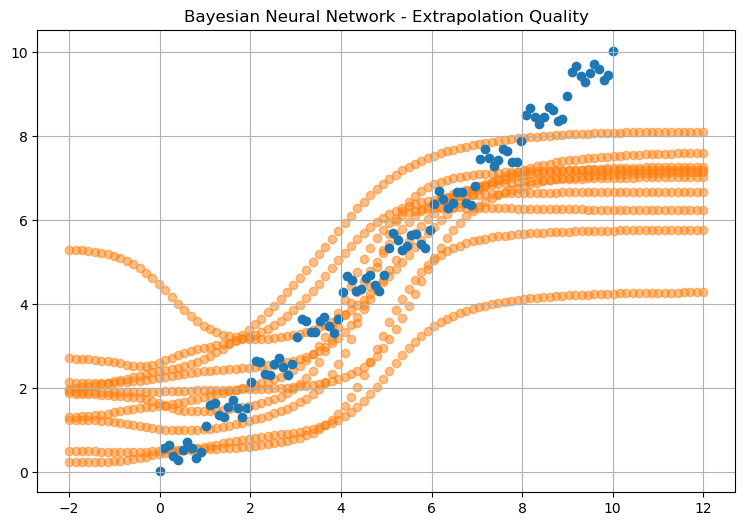

In [19]:
plt.figure(figsize=(9, 6))
for i in range(output_mc_samples):
    plt.scatter(X_test, y_test_samples[i], color='C1', alpha=0.5)
plt.scatter(X, y)
plt.title("Bayesian Neural Network - Extrapolation Quality")
plt.grid()
plt.show()

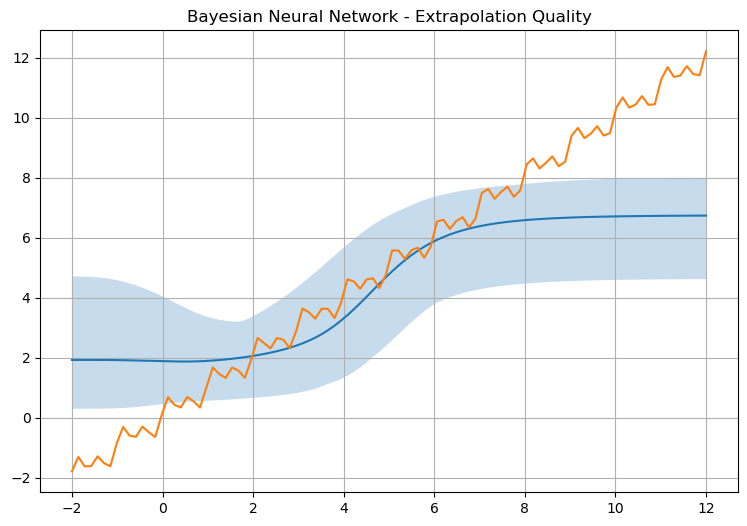

In [20]:
x1 = X_test.numpy().reshape(-1)
y1 = np.mean(y_test_samples, axis = 0)

percentile_2_5 = np.percentile(y_test_samples, 2.5, axis = 0)
percentile_97_5 = np.percentile(y_test_samples, 97.5, axis = 0)


plt.figure(figsize=(9, 6))
plt.plot(x1, y1, label = "Predicted function")
plt.plot(X_test, y_true, label = "True function")
plt.fill_between(x1, percentile_2_5, percentile_97_5, alpha = 0.25, label='95% Confidence')
plt.title("Bayesian Neural Network - Extrapolation Quality")
plt.grid()
plt.show()